# **create 100 1kbp random seqs with same base pair freqs as genome**

In [106]:
import json 
import random
import matplotlib.pyplot as plt
import pandas as pd

In [104]:
triplet_freq_dict = json.load(open("../HumanTripletCounts/GenomeTripletCounts_2020_12_02_genomeWide.txt"))
model = json.load(open("../Human_mutability_model/Model_2020_12_02_genomeWide.txt"))

In [14]:
triplets = []
counts = []
for triplet,count in triplet_freq_dict.items(): 
    triplets.append(triplet)
    counts.append(int(count))

## **build the first dna** 

In [84]:
nTrips = int(5000/3)

In [85]:
chosen_trips =  random.choices(triplets,k=nTrips, weights=counts)

In [86]:
dna = "".join(chosen_trips)

In [87]:
created_counts = [0 for x in triplets]
for triplet in triplets: 
    for i in range(1, len(dna)-1): 
        if dna[i-1:i+2] == triplet: 
            created_counts[triplets.index(triplet)]+= 1
    

In [88]:
chosen_counts = []
for triplet in triplets: 
    chosen_counts.append(chosen_trips.count(triplet))

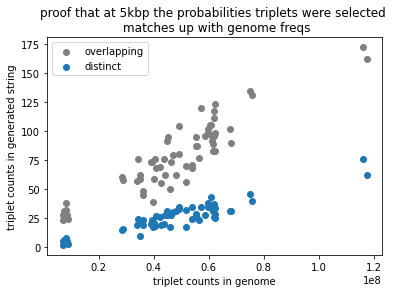

In [98]:
plt.scatter(counts,created_counts,  color = "grey",label="overlapping")
plt.scatter( counts,chosen_counts,label="distinct")
plt.xlabel("triplet counts in genome")
plt.ylabel("triplet counts in generated string")
plt.title("proof that at 5kbp the probabilities triplets were selected \n matches up with genome freqs")
plt.legend()
plt.show()

## **making multiple such dna strings**

In [85]:
chosen_trips =  random.choices(triplets,k=nTrips, weights=counts)

In [86]:
dna = "".join(chosen_trips)

In [99]:
tripFreqRepSeq_dict = {}
for i in range(100): 
    chosen_trips =  random.choices(triplets,k=nTrips, weights=counts)
    dna = "".join(chosen_trips)
    tripFreqRepSeq_dict["trial"+str(i)] = dna

## **running the simulation**

In [100]:
#imports ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from numpy.random import choice
import copy 
#from tqdm import tqdm
import sys 
from datetime import datetime
import time
import timeit
import numpy as np 
import json
from tqdm import tqdm

In [101]:
#defining funtions ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def base_to_mutate(DNA, current_weights, indices): 
    """
    (DNA: str, weights: Dict) -> int
    
    Will return the index of a random choice of a base that will be mutated based on probabilities given by the
    weights dictionary (i.e. the model)
    ex. "ATCGTA" --> index 3 ("G") will mutate
    """

    # NORMALIZE THE POPULATION OF WEIGHTS    
    total_freq = sum(current_weights) - current_weights[0] - current_weights[-1] # remove the start and end weight
    normalized_weights = ["error"]*len(current_weights)
    for index, value in enumerate(current_weights):
        normalized_weights[index] = value/total_freq 
    
    normalized_weights[0] = 0
    normalized_weights[-1] = 0
    # DRAW THE INDEX OF THE BASE THAT WILL BE MUTATED
    base_index = choice(indices, p=normalized_weights) 
    

    # RETURN THE INDEX
    return base_index 

In [102]:
#triplets
triplets = []
for i_1 in ["A", "T", "G", "C"]: 
    for i_2 in ["A", "T", "G", "C"]: 
        for i_3 in ["A", "T", "G", "C"]: 
            triplets.append(i_1+i_2+i_3)

#parameters 
prop_muts = 2

In [105]:
for key,DNA in tqdm(tripFreqRepSeq_dict.items()): 
# for DNA in chosen_intergen_randSeq: 
    
    trialN = list(tripFreqRepSeq_dict.keys()).index(key)
    
    #write initial dna 
    file = open("data/tripletFreqRep/{t}_DNAI.txt".format(t=trialN), "w")
    file.write(str(DNA))
    file.close()

    #set up ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #triplet-count dict 
    triplet_chosen_count_dict = {}
    triplet_into_count_dict = {}
    for triplet in triplets: 
        triplet_chosen_count_dict[triplet] = [0,0,0]  
        triplet_into_count_dict[triplet] = [0,0,0]

    #making the weights 
    current_weights = []
    for i in range(1,len(DNA)-1): 
        triplet = DNA[i-1:i+2]
        current_weights.append(model[triplet][0])

    indices = [i for i in range(1, len(DNA)-1)]
    mut_indices = []

    #making the av muts lists
    #creating the black plotting lists 
    av_mutability = []
    intron_mut = []
    exon_mut = []

    

    #runnign the sim ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for i in range((int(len(DNA)*prop_muts))):
        base_index = base_to_mutate(DNA, current_weights, indices)

        mut_indices.append(base_index)

        #adding the count for "chosen to mutate" in coutns dict 
        c_triplet = DNA[base_index-1: base_index+2]
        c_triplet_left = DNA[base_index-2: base_index+1]
        c_triplet_right = DNA[base_index: base_index+3]    
        triplet_chosen_count_dict[c_triplet_left][0] += 1
        triplet_chosen_count_dict[c_triplet][1] += 1
        triplet_chosen_count_dict[c_triplet_right][2] += 1

        #accurate model INTO probability ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~OR ^ 
        curr_into_bases = []
        curr_into_bases_probs = []
        for into_base, prob in model[c_triplet][1].items(): 
            curr_into_bases.append(into_base)
            curr_into_bases_probs.append(prob)
        mb =  choice(curr_into_bases, p = curr_into_bases_probs)[1]


        #chanaging the dna 
        DNA = DNA[:base_index]+mb+DNA[base_index+1:]

        #updating the weights 
        m_triplet = c_triplet[0]+mb+c_triplet[2]
        m_triplet_left = c_triplet_left[0:2]+mb
        m_triplet_right = mb+c_triplet_right[1:3]
        current_weights[base_index-2]= model[m_triplet_left][0]    
        current_weights[base_index-1]= model[m_triplet][0]
        current_weights[base_index] = model[m_triplet_right][0]
        
        #adding the count for "mutated into thiss" in the triplet dict 
#         triplet_into_count_dict[m_triplet_left][0] += 1 
#         triplet_into_count_dict[m_triplet][1] += 1 
#         triplet_into_count_dict[m_triplet_right][2] += 1 

        #appending the av mut lists 
        av_mutability.append(np.mean(current_weights))


#     text_file = open("data/{t}_triplet_into_count_dict.txt".format(t=trialN), "w")
#     n = text_file.write(json.dumps(triplet_into_count_dict))
#     text_file.close()

#     text_file = open("data/{t}_triplet_chosen_count_dict.txt".format(t=trialN), "w")
#     n = text_file.write(json.dumps(triplet_chosen_count_dict))
#     text_file.close()

    file = open("data/tripletFreqRep/{t}_DNA.txt".format(t=trialN), "w")
    file.write(str(DNA))
    file.close()

    file = open("data/tripletFreqRep/{t}_avMut.txt".format(t=trialN), "w")
    file.write(json.dumps(av_mutability))
    file.close()


100%|██████████| 100/100 [27:41<00:00, 16.62s/it]


### **create plotting df**

In [119]:
data_dict = {"gens":[x for x in range(9996)]}
for i in tqdm(range(trialN)): 
    data_dict["trial"+str(i)] = json.load(open("data/tripletFreqRep/{}_avMut.txt".format(i)))

100%|██████████| 99/99 [00:00<00:00, 207.46it/s]


In [120]:
data_df = pd.DataFrame.from_dict(data_dict)

In [121]:
data_df.to_csv("data/tripletFreqRep/data_df_5kbp.csv")

### **plottign average (scrap)**

In [122]:
avMut_tripFreqRep = []
stderrMut_tripFreqRep = []
for i in tqdm(range(len(json.load(open("data/tripletFreqRep/1_avMut.txt"))))): 
    avMuts_pos = []
    for j in range(trialN): 
        avMuts_pos.append(json.load(open("data/tripletFreqRep/{}_avMut.txt".format(j)))[i])
    avMut_tripFreqRep.append(np.mean(avMuts_pos))
    stderrMut_tripFreqRep.append(np.std(avMuts_pos)/np.sqrt(100))# 100 = the number of trials

  7%|▋         | 743/9996 [05:16<1:05:46,  2.34it/s]


KeyboardInterrupt: 

In [29]:
avMut_allNonCDS[-1], stderrMut_allNonCDS[-1]

(2.93007076963938e-05, 1.5080979157990998e-07)

In [39]:
avMut_allNonCDS[-1], stderrMut_allNonCDS[-1]

(2.9138002107897025e-05, 1.3353437225941693e-07)

In [43]:
belowError_allNonCDS =  []
aboveError_allNonCDS = []
for avMut, stderr in zip(avMut_allNonCDS, stderrMut_allNonCDS): 
    belowError_allNonCDS.append(avMut-stderr)
    aboveError_allNonCDS.append(avMut+stderr)
belowError_allNonCDS = np.array(belowError_allNonCDS)
aboveError_allNonCDS = np.array(aboveError_allNonCDS)

In [44]:
len([x for x in range(2000)])

2000

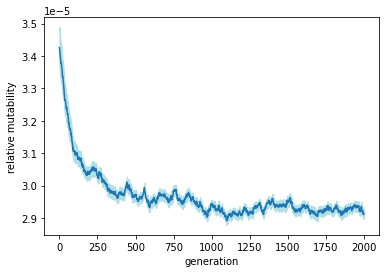

In [76]:
plt.plot([x for x in range(2000)],avMut_allNonCDS)

plt.fill_between([x for x in range(2000)],belowError_allNonCDS,aboveError_allNonCDS, color = "powderblue")
# plt.show()
# timestamp = datetime.now().strftime("%Y/%m/%d_%H:%M:%S").replace("/", "_").replace(":", "_")
# plt.tight_layout()
plt.xlabel("generation")
plt.ylabel("relative mutability")
plt.show()
# plt.savefig("plots/equilibrium_humanIntergenic_100n_1kbp_2xCov_stderr_trial2.pdf")